In [1]:
# Standard Library Imports
from itertools import combinations

# Third-party Library Imports
import random
import numpy as np
import math as math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
)
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

# Local Imports
from modules import forecast

# IPython Magic
%load_ext autoreload
%autoreload 2

### 1. Read SCM & ERA data

In [32]:
scm_era = pd.read_csv("files/ERA/features/scm_era_features_filtered_case38.csv")

# store variables that are used through this notebook
init_months = scm_era["init_month"].unique().tolist()
init_months.remove(12)
unique_scm = [c for c in scm_era.model.unique().tolist() if c != "ERA"] 
weather_columns = [c for c in scm_era.columns if ("rain" in c) or ("tmean" in c)]

# preview
scm_era.sample(2)

,year,model,init_month,yield [kg/ha],yield anomaly [%],tmeanrain_buenos aires coronel suarez_9,tmeansquared_buenos aires coronel suarez_11,tmeanrain_buenos aires coronel suarez_11,rainsquared_buenos aires hipolito yrigoyen_9
921,2004,NASA,9,2768.367390,0.093354,-0.301861,0.040305,0.010959,-0.178548
1161,2012,UKMO,9,2958.105831,-0.077628,3.880604,0.524037,-0.844788,4.061087


### 2. Train yield model and validate for each SCM

In [33]:
# Store results
results_r2 = pd.DataFrame(0.0, index=unique_scm, columns=[9, 10, 11])
results_rmse = pd.DataFrame(0.0, index=unique_scm, columns=[9, 10, 11])
predictions = pd.DataFrame(data={"year":list(range(1993,2017)), "yield anomaly [%]":scm_era.loc[scm_era["model"] == "ERA"].sort_values(by="year")["yield anomaly [%]"].unique()})
for month_of_initialization in init_months + [12]:
    for scm in unique_scm:
        res, _ = forecast.kfold_cross_validation(scm_era, model=scm, init=month_of_initialization, augment=False, no_of_features=3)
        # store performance
        results_rmse.loc[scm, month_of_initialization] = np.round(100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False), 2)
        results_r2.loc[scm, month_of_initialization] = np.round(r2_score(res["yield anomaly [%]"], res["predicted"]), 2)
        # store predictions
        res = res.rename(columns={"predicted":"predicted_{}_{}".format(scm, month_of_initialization)})
        predictions = predictions.merge(res[["year", "predicted_{}_{}".format(scm, month_of_initialization)]], on="year")

#### 2.1 Restructure result dataframes

In [34]:
results_r2 = results_r2.transpose().stack().reset_index().rename(columns={"level_0":"init_month", "level_1":"model", 0:"R2"})
results_r2.loc[results_r2["R2"] < 0, "R2"] = 0
results_rmse = results_rmse.transpose().stack().reset_index().rename(columns={"level_0":"init_month", "level_1":"model", 0:"RRMSE [%]"})

results_r2["model"] = pd.Categorical(results_r2["model"], categories=['BOM', 'CMCC', 'DWD', 'ECCC',
       'ECMWF', 'KMA', 'METFR', 'NASA', 'UKMO','CWB', 'GFDL', 'CCSM4', 'HMC', 'JMA', 'NCEP', 'PNU'])
results_r2 = results_r2.sort_values("model").reset_index(drop=True)

results_rmse["model"] = pd.Categorical(results_rmse["model"], categories=['BOM', 'CMCC', 'DWD', 'ECCC',
       'ECMWF', 'KMA', 'METFR', 'NASA', 'UKMO','CWB', 'GFDL', 'CCSM4', 'HMC', 'JMA', 'NCEP', 'PNU'])
results_rmse = results_rmse.sort_values("model").reset_index(drop=True)

(results_rmse
 .loc[results_rmse["init_month"] != 12]
 .pivot_table(index="model", columns="init_month", values="RRMSE [%]", sort=False)
 .merge(results_r2
        .loc[results_r2["init_month"] != 12]
        .pivot_table(index="model", columns="init_month", values="R2", sort=False), left_index=True, right_index=True, suffixes=("_RRMSE", "_R2"))
 .transpose()
 )

model,BOM,CMCC,DWD,ECCC,ECMWF,KMA,METFR,NASA,UKMO,CWB,GFDL,CCSM4,HMC,JMA,NCEP,PNU
init_month,,,,,,,,,,,,,,,,
9_RRMSE,16.21,14.96,17.83,16.08,15.31,17.45,14.96,15.00,14.73,14.97,31.88,14.17,16.21,14.28,15.94,16.57
10_RRMSE,10.85,10.95,10.82,10.83,10.57,11.13,10.64,10.97,12.01,10.38,10.16,10.57,11.35,11.72,10.93,14.25
11_RRMSE,11.94,10.69,9.98,10.26,10.19,11.80,10.50,9.91,10.90,10.83,11.04,10.82,10.87,11.10,10.52,14.68
9_R2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10_R2,0.36,0.34,0.36,0.36,0.39,0.32,0.38,0.34,0.21,0.41,0.43,0.39,0.30,0.25,0.35,0.00
11_R2,0.22,0.37,0.45,0.42,0.43,0.24,0.40,0.46,0.35,0.36,0.33,0.36,0.35,0.33,0.39,0.00


#### 2.2 Create Figure 2

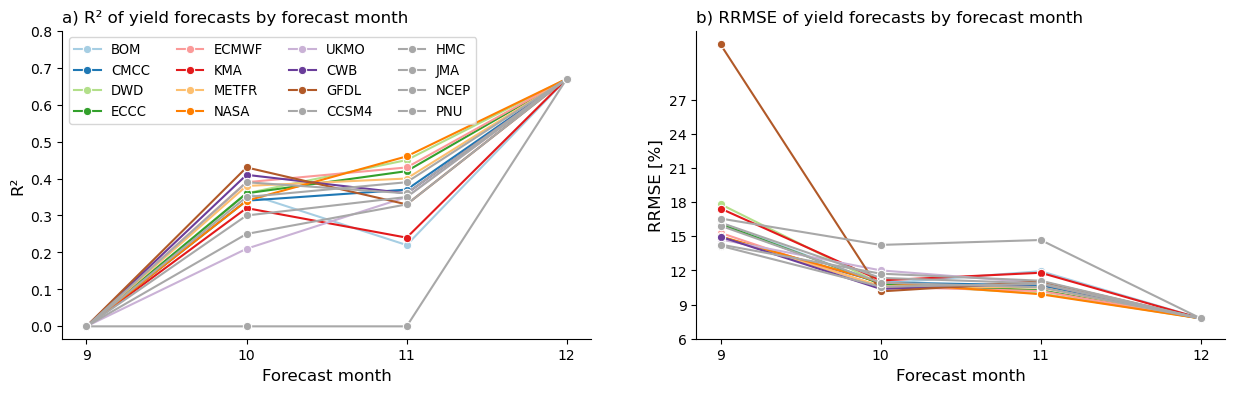

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))
axs = axs.ravel()

sns.lineplot(results_r2, x="init_month", y="R2", hue="model", linewidth=1.5, palette=sns.color_palette("Paired", 10) + sns.color_palette("Paired", 12)[-1:] + 5*["#A8A8A8"], marker="o", ax=axs[0])
axs[0].set_title("a) R\u00b2 of yield forecasts by forecast month", loc="left", fontsize=12)
axs[0].set_xlabel("Forecast month", fontsize=12)
axs[0].set_ylabel("R\u00b2", fontsize=12)
axs[0].set_xticks(list(range(9, 13, 1)))
axs[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
axs[0].legend(fontsize=9.5, ncols=4)
axs[0].spines[['right', 'top']].set_visible(False)

sns.lineplot(results_rmse, x="init_month", y="RRMSE [%]", hue="model", linewidth=1.5, palette=sns.color_palette("Paired", 10) + sns.color_palette("Paired", 12)[-1:] + 5*["#A8A8A8"], marker="o", ax=axs[1])
axs[1].set_title("b) RRMSE of yield forecasts by forecast month", loc="left", fontsize=12)
axs[1].set_xlabel("Forecast month", fontsize=12)
axs[1].set_ylabel("RRMSE [%]", fontsize=12)
axs[1].set_xticks(list(range(9, 13, 1)))
axs[1].set_yticks(list(range(6, 28, 3)))
axs[1].get_legend().remove()
axs[1].spines[['right', 'top']].set_visible(False)

#plt.savefig("figures/figure2.png");
plt.show();


### 3. Analyse MME

In [39]:
def calculate_mme_performance(mme_scm, init_month, prediction_df):
    """
    combine MME based on input and calculates its R2 and RMSE.
    params:
        - mme_scm: list, scm whose outputs should be aggregated
        - init_month: int, month of initialization by which predictions are filtered
        - prediction_df: dataframe, contains the predictions for each year, scm and init month
    returns:
        - (r2, rmse): tuple, of two float values representing the performance of the MME
    """
    prediction_scm = prediction_df.loc[:, [c for c in [l for l in prediction_df.columns if ("predicted" in l)] if (int(c.split("_")[-1]) == init_month) and (c.split("_")[-2] in mme_scm)]]
    
    prediction_scm = prediction_scm.mean(axis=1)
    observed = prediction_df["yield anomaly [%]"]
    
    rrmse = 100 * mse(observed, prediction_scm, squared=False)
    r_squared = r2_score(observed, prediction_scm)
    
    return (r_squared, rrmse)

def assessment_of_different_mme_sizes(df, init, metric_threshold, models, max_size):
    """
    calculate R2 and RRMSE for each combination and MME size
    params:
        - df: Dataframe, contains the predictions by year, init month and SCM
        - init: int, month of initialization for which MME sizes need to be assesssed
        - metric_threshold: float, a threshold for when a performance should be printed out if R2 > threshold
        - models: list, SCM that should be considered to build MME combinations with
        - max_size: int, up to which size MME should be built and assessed
    returns:
        - mme_size_to_results_df: Dataframe, rows are indices of combinations and columns are MME sizes, values are R2
    """
    df = df.copy()    
    relevant_models = models
    mme_size_to_results = {}
    for size in range(1, max_size+1):
        mme_size_to_results[size] = []
        model_combinations = list(combinations([c for c in relevant_models if c != "ERA"], size))
        if len(model_combinations) > 11000:
            print("For MME size {}, there are {} combinations".format(size, len(model_combinations)))
        for i in range(0, len(model_combinations)):
            combi = list(model_combinations[i])
            r_squared, _ = calculate_mme_performance(combi, init, df)
            mme_size_to_results[size].append(r_squared)
            if r_squared > metric_threshold:
                print("R2 is {} for {}".format(np.round(r_squared, 3), "_".join(combi)))

    mme_size_to_results_df = pd.DataFrame.from_dict(mme_size_to_results, orient='index').transpose()
    return mme_size_to_results_df
    

In [40]:
good_models_11 = results_r2.loc[(results_r2["init_month"] == 11) & (results_r2["R2"] > 0), "model"].unique().tolist()
good_models_10 = results_r2.loc[(results_r2["init_month"] == 10) & (results_r2["R2"] > 0), "model"].unique().tolist()

In [41]:
mme_size_to_results_df_9_all = assessment_of_different_mme_sizes(predictions, init=9, metric_threshold=.01, models=unique_scm, max_size=len(unique_scm)).assign(type="All sixteen SCM")
mme_size_to_results_df_10_all = assessment_of_different_mme_sizes(predictions, init=10, metric_threshold=0.45, models=unique_scm, max_size=len(unique_scm)).assign(type="All sixteen SCM")
mme_size_to_results_df_11_all = assessment_of_different_mme_sizes(predictions, init=11, metric_threshold=0.45, models=unique_scm, max_size=len(unique_scm)).assign(type="All sixteen SCM")

mme_size_to_results_df_10 = assessment_of_different_mme_sizes(predictions, init=10, metric_threshold=0.45, models=good_models_10, max_size=len(good_models_10)).assign(type="SCM with R\u00b2 > 0")
mme_size_to_results_df_11 = assessment_of_different_mme_sizes(predictions, init=11, metric_threshold=0.45, models=good_models_11, max_size=len(good_models_11)).assign(type="SCM with R\u00b2 > 0")

mme_9 = mme_size_to_results_df_9_all.set_index("type").stack().reset_index()
mme_10 = pd.concat([mme_size_to_results_df_10, mme_size_to_results_df_10_all]).set_index("type").stack().reset_index()
mme_11 = pd.concat([mme_size_to_results_df_11, mme_size_to_results_df_11_all]).set_index("type").stack().reset_index()

mme_9.columns = ["type", "MME size", "R2"]
mme_10.columns = ["type", "MME size", "R2"]
mme_11.columns = ["type", "MME size", "R2"]

R2 is 0.032 for CCSM4_CWB_JMA
R2 is 0.015 for CCSM4_CWB_HMC_JMA
R2 is 0.018 for CCSM4_CWB_JMA_UKMO
For MME size 7, there are 11440 combinations
For MME size 8, there are 12870 combinations
For MME size 9, there are 11440 combinations
R2 is 0.453 for CWB_GFDL
For MME size 7, there are 11440 combinations
For MME size 8, there are 12870 combinations
For MME size 9, there are 11440 combinations
R2 is 0.454 for DWD
R2 is 0.463 for NASA
R2 is 0.469 for DWD_ECCC
R2 is 0.462 for DWD_ECMWF
R2 is 0.452 for DWD_METFR
R2 is 0.485 for DWD_NASA
R2 is 0.456 for ECCC_NASA
R2 is 0.457 for ECMWF_NASA
R2 is 0.45 for CCSM4_DWD_NASA
R2 is 0.456 for CMCC_DWD_NASA
R2 is 0.465 for CWB_DWD_ECCC
R2 is 0.459 for CWB_DWD_ECMWF
R2 is 0.469 for CWB_DWD_NASA
R2 is 0.455 for CWB_ECCC_NASA
R2 is 0.453 for CWB_ECMWF_NASA
R2 is 0.462 for DWD_ECCC_ECMWF
R2 is 0.465 for DWD_ECCC_HMC
R2 is 0.459 for DWD_ECCC_METFR
R2 is 0.478 for DWD_ECCC_NASA
R2 is 0.452 for DWD_ECCC_NCEP
R2 is 0.455 for DWD_ECMWF_HMC
R2 is 0.454 for DWD_

#### 3.1 Create Figure 3

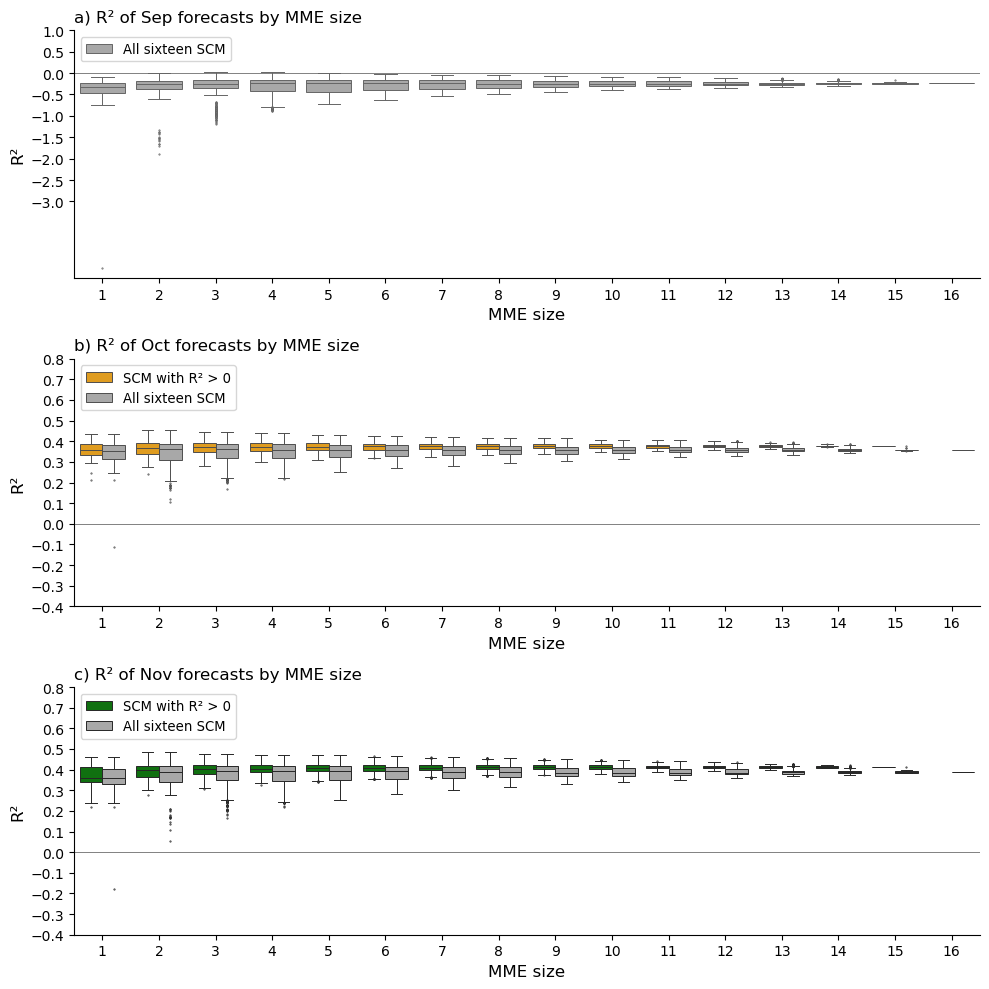

In [42]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs = axs.ravel()
flierprops = dict(markerfacecolor='0.75', markersize=.5,
              linestyle='none')

axs[0].axhline(0, 0, linewidth=.7, color="#818181")
sns.boxplot(mme_9, x="MME size", y="R2", linewidth=.7, hue="type", palette=['#A8A8A8'], flierprops=flierprops, ax=axs[0])
axs[0].set_title("a) R\u00b2 of Sep forecasts by MME size", loc="left", fontsize=12)
axs[0].set_xlabel("MME size", fontsize=12)
axs[0].set_ylabel("R\u00b2", fontsize=12)
axs[0].set_yticks([-3, -2.5, -2, -1.5, -1, -.5, 0, 0.5, 1])
axs[0].get_legend().set_title(None)
axs[0].legend(fontsize=9.5, loc="upper left")
axs[0].spines[['right', 'top']].set_visible(False)

axs[1].axhline(0, 0, linewidth=.7, color="#818181")
sns.boxplot(mme_10, x="MME size", y="R2", linewidth=.7, hue="type", palette=["orange", '#A8A8A8'], flierprops=flierprops, ax=axs[1])
axs[1].set_title("b) R\u00b2 of Oct forecasts by MME size", loc="left", fontsize=12)
axs[1].set_xlabel("MME size", fontsize=12)
axs[1].set_ylabel("R\u00b2", fontsize=12)
axs[1].set_yticks([-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
axs[1].spines[['right', 'top']].set_visible(False)
axs[1].get_legend().set_title(None)
axs[1].legend(fontsize=9.5, loc="upper left")

axs[2].axhline(0, 0, linewidth=.7, color="#818181")
sns.boxplot(mme_11, x="MME size", y="R2", hue="type", linewidth=.7, palette=["green", '#A8A8A8'], flierprops=flierprops, ax=axs[2])
axs[2].set_title("c) R\u00b2 of Nov forecasts by MME size", loc="left", fontsize=12)
axs[2].set_xlabel("MME size", fontsize=12)
axs[2].set_ylabel("R\u00b2", fontsize=12)
axs[2].set_yticks([-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
axs[2].spines[['right', 'top']].set_visible(False)
axs[2].get_legend().set_title(None)
axs[2].legend(fontsize=9.5, loc="upper left")

plt.tight_layout()
#plt.savefig("figures/figure3.svg");
plt.show();


#### 3.2 Create Figure 4

In [43]:
results_r2.model.unique()

['BOM', 'CMCC', 'DWD', 'ECCC', 'ECMWF', ..., 'CCSM4', 'HMC', 'JMA', 'NCEP', 'PNU']
Length: 16
Categories (16, object): ['BOM', 'CMCC', 'DWD', 'ECCC', ..., 'HMC', 'JMA', 'NCEP', 'PNU']

In [44]:
for month_of_initialization in init_months + [12]:
    for mme in [unique_scm, ["CWB", "HMC", "JMA", "NCEP", "PNU"], ["CWB", "GFDL"], ["ECCC", "DWD", "NASA"]]:
        results_r2 = pd.concat([results_r2.reset_index(drop=True), 
                                pd.DataFrame(data={"init_month":[month_of_initialization], "model":["_".join(mme)], "R2":[calculate_mme_performance(mme, month_of_initialization, predictions)][0][0]})])
        results_rmse = pd.concat([results_rmse.reset_index(drop=True), 
                                pd.DataFrame(data={"init_month":[month_of_initialization], "model":["_".join(mme)], "RRMSE [%]":[calculate_mme_performance(mme, month_of_initialization, predictions)][0][1]})])
        results_r2.loc[results_r2["R2"] < 0, "R2"] = 0

results_r2["model"] = results_r2["model"].replace("CWB_HMC_JMA_NCEP_PNU", "MME_BEST_SEP")
results_rmse["model"] = results_rmse["model"].replace("CWB_HMC_JMA_NCEP_PNU", "MME_BEST_SEP")

results_r2["model"] = results_r2["model"].replace("CWB_GFDL", "MME_BEST_OCT")
results_rmse["model"] = results_rmse["model"].replace("CWB_GFDL", "MME_BEST_OCT")

results_r2["model"] = results_r2["model"].replace("ECCC_DWD_NASA", "MME_BEST_NOV")
results_rmse["model"] = results_rmse["model"].replace("ECCC_DWD_NASA", "MME_BEST_NOV")

results_r2["model"] = results_r2["model"].replace("BOM_CCSM4_CMCC_CWB_DWD_ECCC_ECMWF_GFDL_HMC_JMA_KMA_METFR_NASA_NCEP_PNU_UKMO", "MME_ALL_SCM")
results_rmse["model"] = results_rmse["model"].replace("BOM_CCSM4_CMCC_CWB_DWD_ECCC_ECMWF_GFDL_HMC_JMA_KMA_METFR_NASA_NCEP_PNU_UKMO", "MME_ALL_SCM")

In [45]:
results_r2.loc[results_r2["model"].isin(unique_scm), "type"] = "Individual SCM"
results_r2.loc[results_r2["model"].isin(unique_scm) == False, "type"] = results_r2.loc[results_r2["model"].isin(unique_scm) == False, "model"]

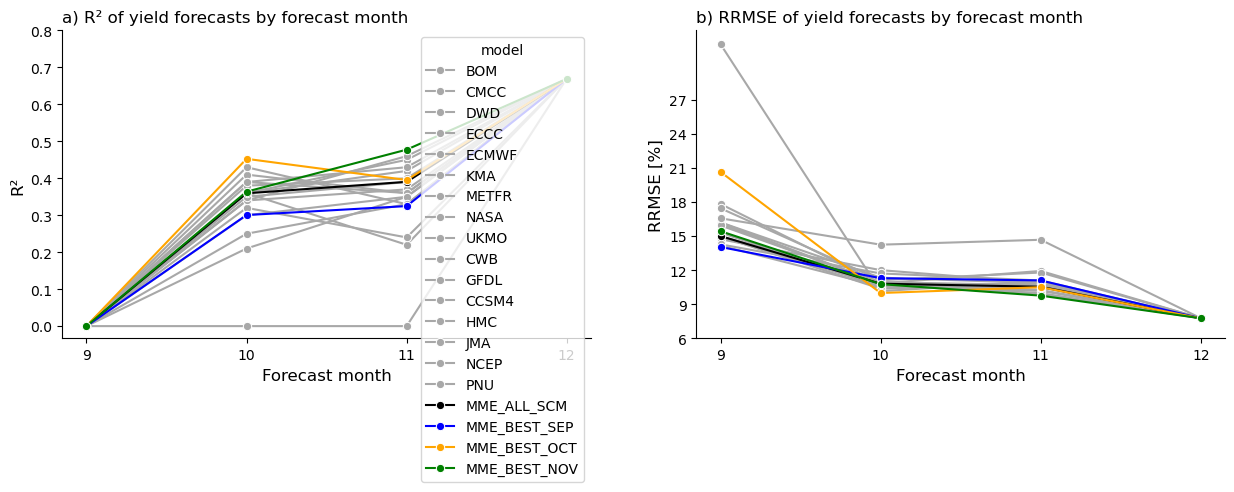

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs = axs.ravel()

sns.lineplot(results_r2, x="init_month", y="R2", hue="model", palette=sns.color_palette(['#A8A8A8'], len(unique_scm))+[ "black", "blue", "orange", "green"], marker="o", ax=axs[0])
axs[0].set_xlabel("Forecast month", fontsize=12)
axs[0].set_title("a) R\u00b2 of yield forecasts by forecast month", loc="left", fontsize=12)
axs[0].set_ylabel("R\u00b2", fontsize=12)
axs[0].set_xticks(list(range(9, 13, 1)))
axs[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
#axs[0].get_legend().remove()
axs[0].spines[['right', 'top']].set_visible(False)
#plt.savefig("r2_model_init_month.svg");

sns.lineplot(results_rmse, x="init_month", y="RRMSE [%]", hue="model", palette=sns.color_palette(['#A8A8A8'], len(unique_scm))+["black", "blue", "orange", "green"], marker="o", ax=axs[1])
axs[1].set_xlabel("Forecast month", fontsize=12)
axs[1].set_title("b) RRMSE of yield forecasts by forecast month", loc="left", fontsize=12)
axs[1].set_ylabel("RRMSE [%]", fontsize=12)
axs[1].set_xticks(list(range(9, 13, 1)))
axs[1].set_yticks(list(range(6, 28, 3)))
axs[1].get_legend().remove()
axs[1].spines[['right', 'top']].set_visible(False)

#plt.savefig("figures/figure4.svg");
plt.show();

### 4. Visualize forecasts by year for Figure 5

In [14]:
best_mme_9 = scm_era.loc[scm_era["model"].isin(["CWB", "HMC", "JMA", "NCEP", "PNU"])].assign(model="MME_{}".format("_".join(["CWB", "HMC", "JMA", "NCEP", "PNU"]))).groupby(["model", "year", "init_month"]).mean().reset_index()
best_mme_10 = scm_era.loc[scm_era["model"].isin(["CWB", "GFDL"])].assign(model="MME_{}".format("_".join(["CWB", "GFDL"]))).groupby(["model", "year", "init_month"]).mean().reset_index()
best_mme_11 = scm_era.loc[scm_era["model"].isin(["DWD", "ECCC", "NASA"])].assign(model="MME_{}".format("_".join(["ECCC", "DWD", "NASA"]))).groupby(["model", "year", "init_month"]).mean().reset_index()
scm_era_mme = pd.concat([best_mme_9, best_mme_10, best_mme_11, scm_era], ignore_index=True)
era_features = scm_era.loc[scm_era["model"] == "ERA"].reset_index(drop=True)

predictions_best_sep_mme, _ = forecast.kfold_cross_validation(scm_era_mme, model="MME_CWB_HMC_JMA_NCEP_PNU", init=9, augment=False, no_of_features=6)
predictions_best_oct_mme, _ = forecast.kfold_cross_validation(scm_era_mme, model="MME_CWB_GFDL", init=10, augment=False, no_of_features=6)
predictions_best_nov_mme, _ = forecast.kfold_cross_validation(scm_era_mme, model="MME_ECCC_DWD_NASA", init=11, augment=False, no_of_features=6)
predictions_era, year_to_features = forecast.kfold_cross_validation(era_features, model="ERA", init=12, augment=False, no_of_features=6)

r2_mme_9 = results_r2.loc[(results_r2["init_month"] == 9) & (results_r2["model"] == "MME_BEST_SEP"), "R2"].values.tolist()[0]
rmse_mme_9 = results_rmse.loc[(results_rmse["init_month"] == 9) & (results_rmse["model"] == "MME_BEST_SEP"), "RRMSE [%]"].values.tolist()[0]
r2_mme_10 = results_r2.loc[(results_r2["init_month"] == 10) & (results_r2["model"] == "MME_BEST_OCT"), "R2"].values.tolist()[0]
r2_mme_11 = results_r2.loc[(results_r2["init_month"] == 11) & (results_r2["model"] == "MME_BEST_NOV"), "R2"].values.tolist()[0]
rmse_mme_10 = results_rmse.loc[(results_rmse["init_month"] == 10) & (results_rmse["model"] == "MME_BEST_OCT"), "RRMSE [%]"].values.tolist()[0]
rmse_mme_11 = results_rmse.loc[(results_rmse["init_month"] == 11) & (results_rmse["model"] == "MME_BEST_NOV"), "RRMSE [%]"].values.tolist()[0]
r2_era = results_r2.loc[(results_r2["init_month"] == 12), "R2"].values.tolist()[0]
rmse_era = results_rmse.loc[(results_rmse["init_month"] == 12), "RRMSE [%]"].values.tolist()[0]

In [15]:
results_r2.model.unique()

array(['BOM', 'CMCC', 'DWD', 'ECCC', 'ECMWF', 'KMA', 'METFR', 'NASA',
       'UKMO', 'CWB', 'GFDL', 'CCSM4', 'HMC', 'JMA', 'NCEP', 'PNU',
       'MME_ALL_SCM', 'MME_BEST_SEP', 'MME_BEST_OCT', 'MME_BEST_NOV'],
      dtype=object)

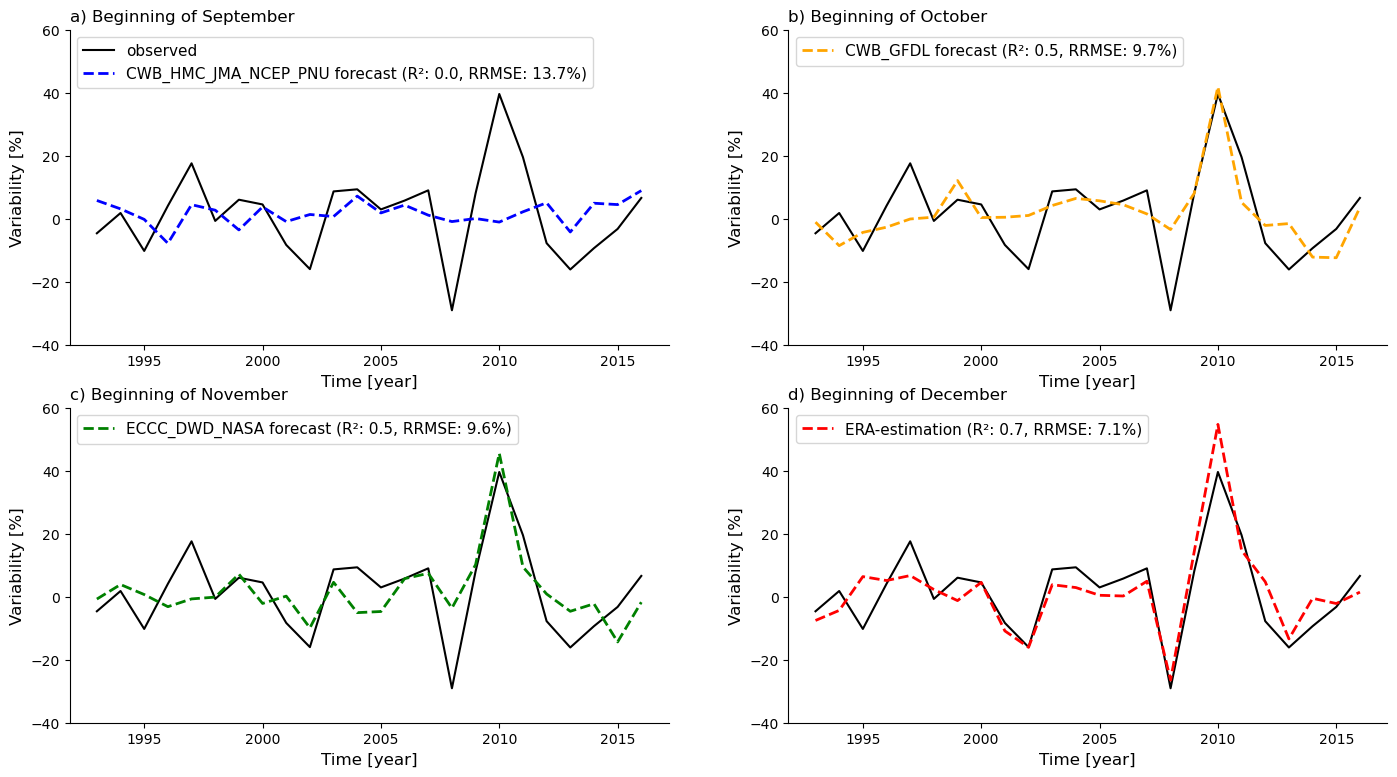

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(17, 9))
axs = axs.ravel()

axs[0].plot(predictions_best_sep_mme["year"], 100*predictions_best_sep_mme["yield anomaly [%]"], color="black", label="observed");
axs[0].plot(predictions_best_sep_mme["year"], 100*predictions_best_sep_mme["predicted"], linewidth=2, linestyle="dashed", color="blue", label="CWB_HMC_JMA_NCEP_PNU forecast (R\u00b2: {}, RRMSE: {}%)".format(round(r2_mme_9, 1), round(rmse_mme_9, 1)));
axs[0].set_title("a) Beginning of September", loc="left", fontsize=12)
axs[0].set_ylabel("Variability [%]", fontsize=12)
axs[0].set_xlabel("Time [year]", fontsize=12)
axs[0].set_yticks(list(range(-40, 70, 20)))
axs[0].spines[['right', 'top']].set_visible(False)
axs[0].legend(loc='upper left', fontsize=11)

axs[1].plot(predictions_best_oct_mme["year"], 100*predictions_best_oct_mme["yield anomaly [%]"], color="black");
axs[1].plot(predictions_best_oct_mme["year"], 100*predictions_best_oct_mme["predicted"], linewidth=2, linestyle="dashed", color="orange", label="CWB_GFDL forecast (R\u00b2: {}, RRMSE: {}%)".format(round(r2_mme_10, 1), round(rmse_mme_10, 1)));
axs[1].set_title("b) Beginning of October", loc="left", fontsize=12)
axs[1].set_ylabel("Variability [%]", fontsize=12)
axs[1].set_xlabel("Time [year]", fontsize=12)
axs[1].set_yticks(list(range(-40, 70, 20)))
axs[1].spines[['right', 'top']].set_visible(False)
axs[1].legend(loc='upper left', fontsize=11)

axs[2].plot(predictions_best_nov_mme["year"], 100*predictions_best_nov_mme["yield anomaly [%]"], color="black");
axs[2].plot(predictions_best_nov_mme["year"], 100*predictions_best_nov_mme["predicted"], linewidth=2, linestyle="dashed", color="green", label="ECCC_DWD_NASA forecast (R\u00b2: {}, RRMSE: {}%)".format(round(r2_mme_11, 1), round(rmse_mme_11, 1)));
axs[2].set_title("c) Beginning of November", loc="left", fontsize=12)
axs[2].set_ylabel("Variability [%]", fontsize=12)
axs[2].set_xlabel("Time [year]", fontsize=12)
axs[2].set_yticks(list(range(-40, 70, 20)))
axs[2].spines[['right', 'top']].set_visible(False)
axs[2].legend(loc='upper left', fontsize=11)

axs[3].plot(predictions_era["year"], 100*predictions_era["yield anomaly [%]"], color="black");
axs[3].plot(predictions_era["year"], 100*predictions_era["predicted"], linewidth=2, linestyle="dashed", color="red", label="ERA-estimation (R\u00b2: {}, RRMSE: {}%)".format(round(r2_era, 1), round(rmse_era, 1)));
axs[3].set_title("d) Beginning of December", loc="left", fontsize=12)
axs[3].set_ylabel("Variability [%]", fontsize=12)
axs[3].set_xlabel("Time [year]", fontsize=12)
axs[3].set_yticks(list(range(-40, 70, 20)))
axs[3].spines[['right', 'top']].set_visible(False)
axs[3].legend(loc='upper left', fontsize=11)

#plt.savefig("figures/figure5.png")
plt.show()


### 5. Analyse 2010 vs. 2008 Cases in October for Figure 6

In [17]:
scm_era_2008_2010_oct = scm_era.loc[(scm_era["init_month"].isin([12, 10])) & (scm_era["year"].isin([2008, 2010])) & (scm_era["model"].isin(["ERA", "CWB", "GFDL"]))]
mme_cwb_gfdl = scm_era_2008_2010_oct.loc[(scm_era_2008_2010_oct["init_month"] == 10) & (scm_era_2008_2010_oct["model"].isin(["CWB", "GFDL"])), [c for c in scm_era_2008_2010_oct.columns if c != "model"]].groupby(["year", "init_month"]).mean().reset_index().assign(model="MME_CWB_GFDL")
scm_era_2008_2010_oct = pd.concat([mme_cwb_gfdl, scm_era_2008_2010_oct], ignore_index=True)

scm_2008_2010_oct = scm_era_2008_2010_oct.loc[scm_era_2008_2010_oct["model"] != "ERA"]
era_2008_2010_oct = scm_era_2008_2010_oct.loc[scm_era_2008_2010_oct["model"] == "ERA"].set_index("year")[weather_columns]

all_bias = []
for model in ["CWB", "GFDL", "MME_CWB_GFDL"]:
    current_scm = scm_2008_2010_oct.loc[(scm_2008_2010_oct["model"] == model) & (scm_2008_2010_oct["init_month"] == 10)].set_index("year")
    current_scm_bias = abs(current_scm[weather_columns] - era_2008_2010_oct)
    current_scm_info = current_scm[['model', 'init_month', 'yield [kg/ha]', 'yield anomaly [%]']]
    current_scm_bias.loc[:, [c for c in weather_columns if int(c.split("_")[-1]) < 10]] = np.nan
    current_scm = pd.concat([current_scm_info, current_scm_bias], axis=1)
    all_bias.append(current_scm)

all_bias = pd.concat(all_bias)
all_bias = all_bias[["model"] + weather_columns].reset_index()

bias_2008 = all_bias.loc[all_bias["year"] == 2008, ["model"] + [c for c in year_to_features[2008].tolist() if ("_9" not in c)]].set_index(["model"]).stack().reset_index()
bias_2010 = all_bias.loc[all_bias["year"] == 2010, ["model"] + [c for c in year_to_features[2010].tolist() if ("_9" not in c)]].set_index(["model"]).stack().reset_index()

bias_2010.columns = ["model", "feature", "MAE"]
bias_2008.columns = ["model", "feature", "MAE"]

bias_2010_mme = bias_2010.loc[bias_2010["model"].isin(['CWB', 'GFDL', 'MME_CWB_GFDL']), :].reset_index(drop=True).copy()
bias_2008_mme = bias_2008.loc[bias_2008["model"].isin(['CWB', 'GFDL', 'MME_CWB_GFDL']), :].reset_index(drop=True).copy()

bias_2010_mme["feature"] = pd.Categorical(bias_2010_mme["feature"], categories=['tmeanrain_santa fe san justo_11', 'rainsquared_santa fe san justo_11', 'rainsquared_santa fe las colonias_11', 'tmeanrain_buenos aires coronel suarez_11', 'tmeansquared_buenos aires coronel suarez_11'])
bias_2010_mme = bias_2010_mme.sort_values("feature", ascending=False)
bias_2010_mme["feature"] = bias_2010_mme["feature"].astype(str)

bias_2008_mme["feature"] = pd.Categorical(bias_2008_mme["feature"], categories=['tmeanrain_entre rios nogoya_10', 'tmeanrain_santa fe san justo_10', 'rainsquared_santa fe las colonias_11', 'rainsquared_santa fe san justo_11', 'tmeanrain_buenos aires coronel suarez_11'])
bias_2008_mme = bias_2008_mme.sort_values("feature", ascending=True)
bias_2008_mme["feature"] = bias_2008_mme["feature"].astype(str)

In [26]:
scm_2008_2010_oct.loc[((scm_2008_2010_oct["year"] == 2010)), :]

,year,init_month,yield [kg/ha],yield anomaly [%],tmeanrain_santa fe san justo_10,rainsquared_santa fe san justo_11,rainsquared_santa fe las colonias_11,tmeanrain_santa fe san justo_11,tmeanrain_buenos aires hipolito yrigoyen_11,tmeanrain_buenos aires coronel suarez_11,rainsquared_buenos aires hipolito yrigoyen_9,tmeanrain_entre rios nogoya_10,tmeansquared_buenos aires coronel suarez_11,model
1,2010,10,3933.646839,0.395993,0.258304,1.256762,1.204704,-1.175791,0.318907,-0.013789,7.54278,1.199898,-0.262259,MME_CWB_GFDL
3,2010,10,3933.646839,0.395993,-0.586469,1.388050,1.421708,-0.622505,0.233740,-0.230850,7.54278,0.118045,0.283305,CWB
7,2010,10,3933.646839,0.395993,1.103076,1.125474,0.987700,-1.729078,0.404075,0.203272,7.54278,2.281752,-0.807822,GFDL


In [25]:
era_2008_2010_oct

,tmeanrain_santa fe san justo_10,rainsquared_santa fe san justo_11,rainsquared_santa fe las colonias_11,tmeanrain_santa fe san justo_11,tmeanrain_buenos aires hipolito yrigoyen_11,tmeanrain_buenos aires coronel suarez_11,rainsquared_buenos aires hipolito yrigoyen_9,tmeanrain_entre rios nogoya_10,tmeansquared_buenos aires coronel suarez_11
year,,,,,,,,,
2008,-0.042816,1.027097,0.857085,-4.589046,-1.595207,-4.421606,-0.641597,-0.545712,10.625846
2010,2.036838,-0.287960,-0.025316,0.561675,0.443922,0.267665,7.542780,2.337022,-0.449381


In [21]:
all_bias.loc[(all_bias["year"] == 2010), ["year", "model", "tmeansquared_buenos aires coronel suarez_11"]]

,year,model,tmeansquared_buenos aires coronel suarez_11
1,2010,CWB,0.732685
3,2010,GFDL,0.358441
5,2010,MME_CWB_GFDL,0.187122


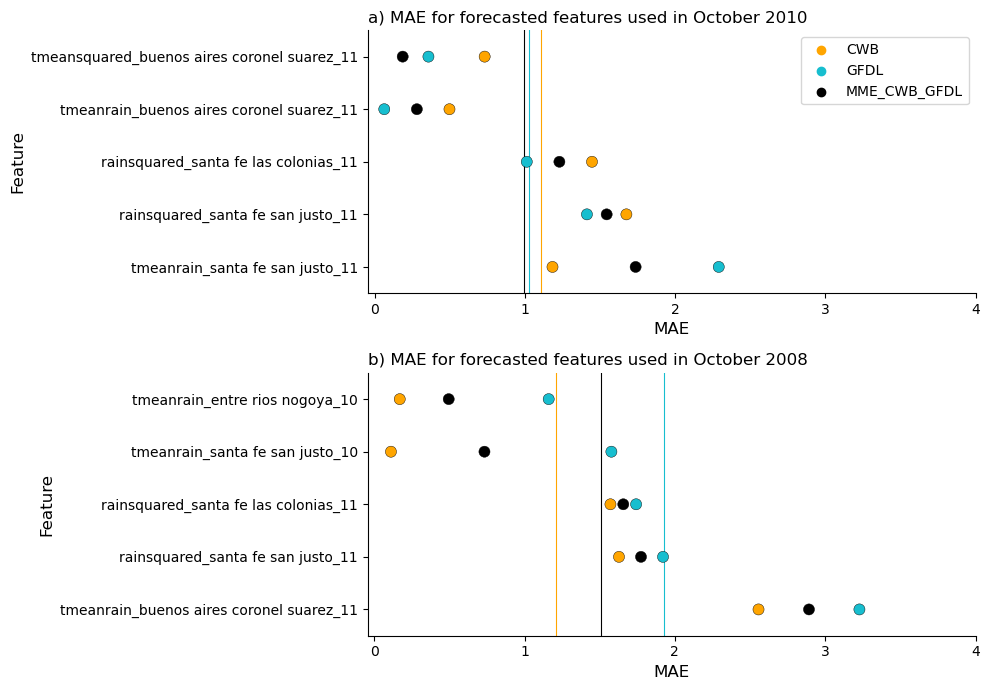

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))
axs = axs.ravel()

sns.stripplot(data=bias_2010_mme, x="MAE", y="feature", orient="h", s=8, marker="o", linewidth=.3, hue="model", palette=["#FFA500", "#17BECF", "black"], jitter=False, ax=axs[0])
axs[0].set_title("a) MAE for forecasted features used in October 2010", loc="left")
axs[0].set_xlabel("MAE", fontsize=12)
axs[0].set_xticks([0, 1, 2, 3, 4])
axs[0].set_ylabel("Feature", fontsize=12)
axs[0].legend(loc='upper right')
axs[0].axvline(1.107683, color="#FFA500", lw=.8)
axs[0].axvline(1.028008, color="#17BECF", lw=.8)
axs[0].axvline(0.996157, color="black", lw=.8)
#axs[0].xaxis.grid(True, linestyle="--") 
axs[0].spines[['right', 'top']].set_visible(False)


sns.stripplot(data=bias_2008_mme, x="MAE", y="feature", orient="h", s=8, marker="o", linewidth=.3, hue="model", palette=["#FFA500", "#17BECF", "black"], jitter=False, ax=axs[1])
axs[1].set_title("b) MAE for forecasted features used in October 2008", loc="left")
axs[1].set_xlabel("MAE", fontsize=12)
axs[1].set_xticks([0, 1, 2, 3, 4])
axs[1].set_ylabel("Feature", fontsize=12)
axs[1].get_legend().remove()
#axs[1].xaxis.grid(True, linestyle="--") 
axs[1].axvline(1.207257, color='#FFA500', lw=.8)
axs[1].axvline(1.925639, color='#17BECF', lw=.8)
axs[1].axvline(1.510286, color='black', lw=.8)
axs[1].spines[['right', 'top']].set_visible(False)

#plt.savefig("figures/figure6.svg");
plt.tight_layout()
plt.show();



In [109]:
bias_2008_mme.groupby("model")["MAE"].mean()

model
CWB             1.207257
GFDL            1.925639
MME_CWB_GFDL    1.510286
Name: MAE, dtype: float64

In [110]:
bias_2010_mme.groupby("model")["MAE"].mean()

model
CWB             1.107683
GFDL            1.028008
MME_CWB_GFDL    0.996157
Name: MAE, dtype: float64

In [ ]:
df_no_era = x_y_cv.loc[(x_y_cv["init_month"] == 10) & (x_y_cv["model"] != "ERA"), ['model', 'year', 'init_month'] + relevant_columns].reset_index(drop=True)
df_era = x_y_cv.loc[(x_y_cv["init_month"] == 12) & (x_y_cv["model"] == "ERA"), ['model', 'year', 'init_month'] + relevant_columns].reset_index(drop=True)
N = len(df_no_era["model"].unique().tolist())
model_to_error = {}

# calculate bias between each model and ERA
corr_matrices = []
for col in relevant_columns:
    model_to_error[col] = {}
    for model in relevant_models:
        bias = np.array(df_no_era.loc[df_no_era["model"] == model, col]) - np.array(df_era.loc[df_era["model"] == "ERA", col])
        model_to_error[col][model] = bias.flatten()
    df = pd.DataFrame(model_to_error[col])
    correlation_matrix = df.corr()
    corr_matrices.append(correlation_matrix)

correlation_matrix = sum(corr_matrices) / len(corr_matrices)
correlation_matrix

,CCSM4,GFDL,BOM,CWB,KMA,PNU,DWD,ECMWF,JMA,METFR,UKMO
CCSM4,1.000000,0.550825,0.734358,0.666739,0.613589,0.726918,0.633683,0.727742,0.712364,0.733284,0.648847
GFDL,0.550825,1.000000,0.533879,0.674369,0.573497,0.587739,0.642397,0.571632,0.625683,0.657740,0.597665
BOM,0.734358,0.533879,1.000000,0.663234,0.671617,0.782236,0.670352,0.764647,0.699529,0.651531,0.582231
CWB,0.666739,0.674369,0.663234,1.000000,0.660079,0.693930,0.758087,0.791582,0.646170,0.637103,0.689580
KMA,0.613589,0.573497,0.671617,0.660079,1.000000,0.722914,0.623518,0.646611,0.651347,0.587890,0.603332
PNU,0.726918,0.587739,0.782236,0.693930,0.722914,1.000000,0.633896,0.833941,0.743919,0.726759,0.642666
DWD,0.633683,0.642397,0.670352,0.758087,0.623518,0.633896,1.000000,0.747275,0.647761,0.674163,0.646619
ECMWF,0.727742,0.571632,0.764647,0.791582,0.646611,0.833941,0.747275,1.000000,0.746020,0.687342,0.669243
JMA,0.712364,0.625683,0.699529,0.646170,0.651347,0.743919,0.647761,0.746020,1.000000,0.670142,0.624956
METFR,0.733284,0.657740,0.651531,0.637103,0.587890,0.726759,0.674163,0.687342,0.670142,1.000000,0.779600


In [ ]:
df_no_era = x_y_cv.loc[(x_y_cv["init_month"] == 10) & (x_y_cv["model"] != "ERA"), ['model', 'year', 'init_month'] + relevant_columns].reset_index(drop=True)
df_era = x_y_cv.loc[(x_y_cv["init_month"] == 12) & (x_y_cv["model"] == "ERA"), ['model', 'year', 'init_month'] + relevant_columns].reset_index(drop=True)
N = len(df_no_era["model"].unique().tolist())
model_to_error = {}

# calculate bias between each model and ERA
corr_matrices = []
for col in relevant_columns:
    model_to_error[col] = {}
    for model in relevant_models:
        bias = np.array(df_no_era.loc[df_no_era["model"] == model, col]) - np.array(df_era.loc[df_era["model"] == "ERA", col])
        model_to_error[col][model] = bias.flatten()
    df = pd.DataFrame(model_to_error[col])
    correlation_matrix = df.corr()
    corr_matrices.append(correlation_matrix)

correlation_matrix = sum(corr_matrices) / len(corr_matrices)
correlation_matrix

,CCSM4,GFDL,BOM,CWB,KMA,PNU,DWD,ECMWF,JMA,METFR,UKMO
CCSM4,1.000000,0.550825,0.734358,0.666739,0.613589,0.726918,0.633683,0.727742,0.712364,0.733284,0.648847
GFDL,0.550825,1.000000,0.533879,0.674369,0.573497,0.587739,0.642397,0.571632,0.625683,0.657740,0.597665
BOM,0.734358,0.533879,1.000000,0.663234,0.671617,0.782236,0.670352,0.764647,0.699529,0.651531,0.582231
CWB,0.666739,0.674369,0.663234,1.000000,0.660079,0.693930,0.758087,0.791582,0.646170,0.637103,0.689580
KMA,0.613589,0.573497,0.671617,0.660079,1.000000,0.722914,0.623518,0.646611,0.651347,0.587890,0.603332
PNU,0.726918,0.587739,0.782236,0.693930,0.722914,1.000000,0.633896,0.833941,0.743919,0.726759,0.642666
DWD,0.633683,0.642397,0.670352,0.758087,0.623518,0.633896,1.000000,0.747275,0.647761,0.674163,0.646619
ECMWF,0.727742,0.571632,0.764647,0.791582,0.646611,0.833941,0.747275,1.000000,0.746020,0.687342,0.669243
JMA,0.712364,0.625683,0.699529,0.646170,0.651347,0.743919,0.647761,0.746020,1.000000,0.670142,0.624956
METFR,0.733284,0.657740,0.651531,0.637103,0.587890,0.726759,0.674163,0.687342,0.670142,1.000000,0.779600


In [ ]:
metrics = []
correlations = []
sizes = []
models_mme = []
for size in range(2,12):
    model_combinations = list(combinations([c for c in good_models if c != "ERA"], size))
    print(len(model_combinations))
    for i in range(0, len(model_combinations)):
        combi = list(model_combinations[i])
        mme = x_y_cv.loc[x_y_cv["model"].isin(combi)].assign(model="MME_{}".format("_".join(combi))).groupby(["model", "year", "init_month"]).mean().reset_index()
        x_y_cv_mme = pd.concat([mme, x_y_cv], ignore_index=True)
        res, _ = forecast.kfold_cross_validation(x_y_cv_mme, model="MME_{}".format("_".join(combi)), init=10, no_of_features=7)
        #metric = pearsonr(res["yield anomaly [%]"], res["predicted"])[0]
        metric = r2_score(res["yield anomaly [%]"], res["predicted"])
        sizes.append(size)
        models_mme.append("_".join(combi))
        metrics.append(metric)
        corr = correlation_matrix.loc[correlation_matrix.index.isin(combi), combi].where(np.triu(np.ones(len(combi)), k=1).astype(bool)).stack().mean()
        correlations.append(corr)
    

55
165
330
462
462
330
165
55
11
1


In [ ]:
metrics_to_correlation = pd.DataFrame(
    {'metrics': metrics,
     'MME size': sizes,
     'correlation': correlations,
     'models': models_mme
    })
metrics_to_correlation.head()

,metrics,MME size,correlation,models
0,0.478795,2,0.550825,CCSM4_GFDL
1,0.390075,2,0.734358,CCSM4_BOM
2,0.362848,2,0.666739,CCSM4_CWB
3,0.345998,2,0.613589,CCSM4_KMA
4,0.223102,2,0.726918,CCSM4_PNU


In [ ]:
metrics_subset = metrics_to_correlation.loc[metrics_to_correlation["MME size"] > 1].reset_index(drop=True)
idx = metrics_subset.groupby(['MME size'])['metrics'].transform(max) == metrics_subset['metrics']
metrics_subset = metrics_subset[idx].reset_index(drop=True)

In [ ]:
metrics_subset

,metrics,MME size,correlation,models
0,0.478795,2,0.550825,CCSM4_GFDL
1,0.503322,3,0.606354,CCSM4_GFDL_BOM
2,0.499552,4,0.637234,CCSM4_GFDL_BOM_CWB
3,0.496065,5,0.634218,CCSM4_GFDL_BOM_CWB_KMA
4,0.488939,6,0.645152,CCSM4_GFDL_BOM_CWB_KMA_JMA
5,0.478576,7,0.648332,CCSM4_GFDL_BOM_CWB_KMA_JMA_METFR
6,0.456247,8,0.652319,CCSM4_GFDL_BOM_CWB_KMA_DWD_JMA_METFR
7,0.432174,9,0.663423,CCSM4_GFDL_BOM_CWB_KMA_PNU_DWD_JMA_METFR
8,0.412493,10,0.661997,CCSM4_GFDL_BOM_CWB_KMA_DWD_ECMWF_JMA_METFR_UKMO
9,0.395411,11,0.670632,CCSM4_GFDL_BOM_CWB_KMA_PNU_DWD_ECMWF_JMA_METFR...


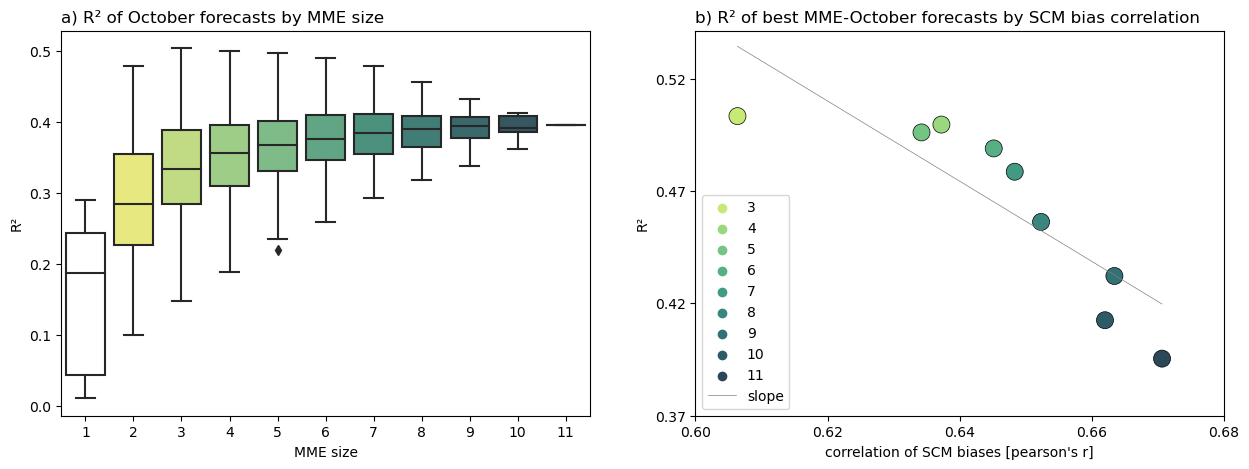

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs = axs.ravel()

color_palette =['white', '#FAFA6E', "#C7EA75", "#9AD87D", '#74C582', '#57B085', '#419B83', '#38867E', '#327174', '#2D5C67', '#2A4858']
sns.boxplot(mme_size_to_results_df, palette=color_palette, ax=axs[0])
axs[0].set_title("a) R\u00b2 of October forecasts by MME size", loc="left")
axs[0].set_xlabel("MME size")
axs[0].set_ylabel("R\u00b2")
#plt.savefig("r2_by_mme_size.svg");
#plt.show();

color_palette =["#C7EA75", "#9AD87D", '#74C582', '#57B085', '#419B83', '#38867E', '#327174', '#2D5C67', '#2A4858']
sns.scatterplot(data=metrics_subset, x="correlation", y="metrics", ax=axs[1], s=150, edgecolor="black", linewidth=.5, hue="MME size", palette=color_palette)
sns.regplot(x='correlation', y='metrics', data=metrics_subset, 
            ax=axs[1], 
            color="gray",
            label='slope',
            scatter=False,
            ci=None,
            line_kws={'linewidth':.5}
            )
axs[1].set_yticks([.37, .42, .47, .52]);
axs[1].set_xticks([.6, .62, .64, .66, .68]);
axs[1].set_title("b) R\u00b2 of best MME-October forecasts by SCM bias correlation", loc="left")
axs[1].set_xlabel("correlation of SCM biases [pearson's r]")
axs[1].set_ylabel("R\u00b2")
axs[1].legend(loc="lower left")
plt.savefig("figure3.svg");
plt.show();




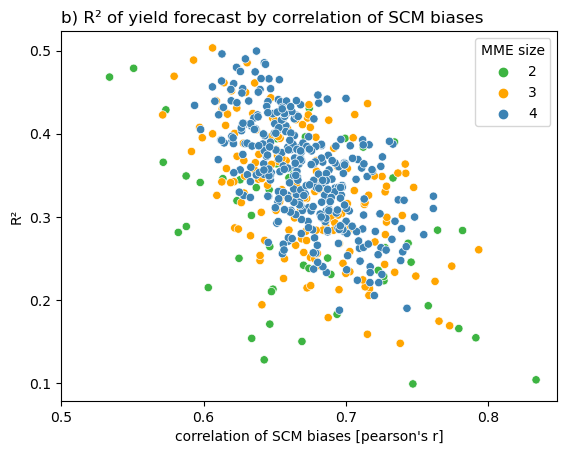

In [ ]:

#sns.scatterplot(data=metrics_to_correlation, x="correlation", y="metrics")
sns.scatterplot(x = "correlation", y = "metrics", data = metrics_subset, color="gray", hue="MME size", palette=["#3DB442", "orange", "#3D83B4"])
#sns.scatterplot(x = "correlation", y = "metrics", data = metrics_subset[idx], hue="MME size", marker="o")
plt.title("b) R\u00b2 of yield forecast by correlation of SCM biases", loc="left")
plt.xlabel("correlation of SCM biases [pearson's r]")
plt.ylabel("R\u00b2")
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5])
plt.xticks([0.5, 0.6, 0.7, 0.8])
#plt.savefig("r2_by_correlation.svg");
plt.show();